### Shuai Ding


#### Q2: Machine learning methods (predictive model) trained on this data are more reliable, precise and faster than some established radiological methods. Doctors could precisely diagnose brain tumor in a shorter amount of time. 

In [0]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3




In [2]:
# After saving the following zip file to your working directory extract all files and folders from zip file to local folder.

!unzip brain_tumor_dataset.zip  


Archive:  brain_tumor_dataset.zip
   creating: brain_tumor_dataset/no/
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brai

In [3]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [155, 98]
[['brain_tumor_dataset/yes/Y247.JPG', 'brain_tumor_dataset/yes/Y82.jpg', 'brain_tumor_dataset/yes/Y37.jpg', 'brain_tumor_dataset/yes/Y22.jpg', 'brain_tumor_dataset/yes/Y44.JPG', 'brain_tumor_dataset/yes/Y254.jpg', 'brain_tumor_dataset/yes/Y92.jpg', 'brain_tumor_dataset/yes/Y76.jpg', 'brain_tumor_dataset/yes/Y25.jpg', 'brain_tumor_dataset/yes/Y183.jpg', 'brain_tumor_dataset/yes/Y40.JPG', 'brain_tumor_dataset/yes/Y106.jpg', 'brain_tumor_dataset/yes/Y73.jpg', 'brain_tumor_dataset/yes/Y50.JPG', 'brain_tumor_dataset/yes/Y250.jpg', 'brain_tumor_dataset/yes/Y18.JPG', 'brain_tumor_dataset/yes/Y66.JPG', 'brain_tumor_dataset/yes/Y62.jpg', 'brain_tumor_dataset/yes/Y194.jpg', 'brain_tumor_dataset/yes/Y253.JPG', 'brain_tumor_dataset/yes/Y259.JPG', 'brain_tumor_dataset/yes/Y15.jpg', 'brain_tumor_dataset/yes/Y159.JPG', 'brain_tumor_dataset/yes/Y243.JPG', 'brain_tumor_dataset/yes/Y36.JPG', 'brain_tumor_dataset/yes/Y60.jpg', 'brain_tumor_dataset/yes/Y69.jpg

In [38]:
# Let's explore the details of the image data using load_img from keras
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

# It's an RGB image, so we can import using the following approach.

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


In [0]:
# Import image, load to array of shape height, width, channels, then min/max transform.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model


In [40]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape # 

253
(224, 224, 3)
0.0
1.0


(253, 224, 224, 3)

In [41]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


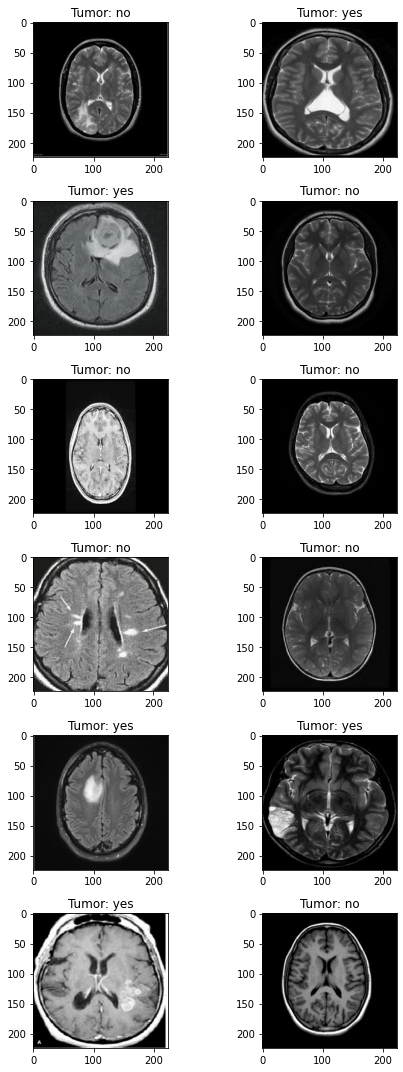

In [42]:
fig,ax=plt.subplots(6,2)
fig.set_size_inches(7,15)
for i in range(6):
    for j in range (2):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

In [43]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)


y_train 



,no,yes
38,0,1
143,0,1
84,0,1
55,0,1
217,1,0
...,...,...
106,0,1
14,0,1
92,0,1
179,1,0


## First Keras Convolutional Neural Net:

In [93]:
# Let's set a baseline plain vanilla network model to use as a baseline for convnet models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(32,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dense(32, activation='relu'))
      model.add(Dense(32, activation='relu'))
      model.add(Dense(32, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 
                                                  
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
7/7 [==============================] - 10s 1s/step - loss: 0.6537 - accuracy: 0.6139 - val_loss: 0.7355 - val_accuracy: 0.4706
Epoch 2/5
7/7 [==============================] - 10s 1s/step - loss: 0.5656 - accuracy: 0.7178 - val_loss: 0.7724 - val_accuracy: 0.5294
Epoch 3/5
7/7 [==============================] - 10s 1s/step - loss: 0.5246 - accuracy: 0.7376 - val_loss: 0.7740 - val_accuracy: 0.5882
Epoch 4/5
7/7 [==============================] - 10s 1s/step - loss: 0.5035 - accuracy: 0.7822 - val_loss: 0.6134 - val_accuracy: 0.6667
Epoch 5/5
7/7 [==============================] - 10s 1s/step - loss: 0.5004 - accuracy: 0.7822 - val_loss: 0.7767 - val_accuracy: 0.6275


In [94]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size 192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 2 categories
    tf.keras.layers.Dense(2, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/5
7/7 [==============================] - 14s 2s/step - loss: 0.6611 - accuracy: 0.6337 - val_loss: 0.7362 - val_accuracy: 0.5294
Epoch 2/5
7/7 [==============================] - 14s 2s/step - loss: 0.6186 - accuracy: 0.6337 - val_loss: 0.6608 - val_accuracy: 0.5294
Epoch 3/5
7/7 [==============================] - 14s 2s/step - loss: 0.5511 - accuracy: 0.7178 - val_loss: 0.6767 - val_accuracy: 0.6863
Epoch 4/5
7/7 [==============================] - 14s 2s/step - loss: 0.5027 - accuracy: 0.7525 - val_loss: 0.7246 - val_accuracy: 0.6863
Epoch 5/5
7/7 [==============================] - 14s 2s/step - loss: 0.4765 - accuracy: 0.8020 - val_loss: 0.6881 - val_accuracy: 0.7059


### Second model

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(32,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(32, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(32, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(32, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 
                                                  
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
7/7 [==============================] - 20s 3s/step - loss: 0.6212 - accuracy: 0.5941 - val_loss: 0.6801 - val_accuracy: 0.6667
Epoch 2/5
7/7 [==============================] - 19s 3s/step - loss: 0.5763 - accuracy: 0.6634 - val_loss: 0.6655 - val_accuracy: 0.6667
Epoch 3/5
7/7 [==============================] - 19s 3s/step - loss: 0.5053 - accuracy: 0.7921 - val_loss: 0.6672 - val_accuracy: 0.5294
Epoch 4/5
7/7 [==============================] - 20s 3s/step - loss: 0.5141 - accuracy: 0.7129 - val_loss: 0.6566 - val_accuracy: 0.6078
Epoch 5/5
7/7 [==============================] - 20s 3s/step - loss: 0.4975 - accuracy: 0.7921 - val_loss: 0.6515 - val_accuracy: 0.6863


In [77]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size 192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 2 categories
    tf.keras.layers.Dense(2, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/5
7/7 [==============================] - 15s 2s/step - loss: 0.6578 - accuracy: 0.5990 - val_loss: 0.7518 - val_accuracy: 0.5294
Epoch 2/5
7/7 [==============================] - 14s 2s/step - loss: 0.6297 - accuracy: 0.6337 - val_loss: 0.6565 - val_accuracy: 0.5686
Epoch 3/5
7/7 [==============================] - 14s 2s/step - loss: 0.5830 - accuracy: 0.7079 - val_loss: 0.6655 - val_accuracy: 0.5882
Epoch 4/5
7/7 [==============================] - 15s 2s/step - loss: 0.5044 - accuracy: 0.7673 - val_loss: 0.7550 - val_accuracy: 0.7059
Epoch 5/5
7/7 [==============================] - 14s 2s/step - loss: 0.4913 - accuracy: 0.7673 - val_loss: 0.8429 - val_accuracy: 0.6667


### Third model


In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.0001)

      model = Sequential()
      model.add(Dense(32,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(32, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(32, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(32, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 
                                                  
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
7/7 [==============================] - 19s 3s/step - loss: 0.6724 - accuracy: 0.5297 - val_loss: 0.6844 - val_accuracy: 0.5294
Epoch 2/5
7/7 [==============================] - 19s 3s/step - loss: 0.6295 - accuracy: 0.6337 - val_loss: 0.6816 - val_accuracy: 0.5294
Epoch 3/5
7/7 [==============================] - 19s 3s/step - loss: 0.5946 - accuracy: 0.6337 - val_loss: 0.6799 - val_accuracy: 0.5294
Epoch 4/5
7/7 [==============================] - 19s 3s/step - loss: 0.6170 - accuracy: 0.6337 - val_loss: 0.6775 - val_accuracy: 0.5294
Epoch 5/5
7/7 [==============================] - 19s 3s/step - loss: 0.6094 - accuracy: 0.6337 - val_loss: 0.6757 - val_accuracy: 0.5294


In [84]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size 192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 2 categories
    tf.keras.layers.Dense(2, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/5
7/7 [==============================] - 35s 5s/step - loss: 0.6452 - accuracy: 0.5842 - val_loss: 0.6928 - val_accuracy: 0.5490
Epoch 2/5
7/7 [==============================] - 33s 5s/step - loss: 0.5385 - accuracy: 0.7327 - val_loss: 0.7891 - val_accuracy: 0.6667
Epoch 3/5
7/7 [==============================] - 34s 5s/step - loss: 0.5116 - accuracy: 0.7822 - val_loss: 0.6050 - val_accuracy: 0.7059
Epoch 4/5
7/7 [==============================] - 33s 5s/step - loss: 0.4669 - accuracy: 0.8069 - val_loss: 0.7942 - val_accuracy: 0.6863
Epoch 5/5
7/7 [==============================] - 33s 5s/step - loss: 0.4467 - accuracy: 0.8119 - val_loss: 0.5974 - val_accuracy: 0.7059


## Submit a model to AI Model Share Competition

In [12]:
# Load libraries for onnx model conversion (keras to onnx)
! pip3 install keras2onnx
! pip3 install onnxruntime

     |████████████████████████████████| 225kB 3.2MB/s 
     |████████████████████████████████| 4.8MB 5.8MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
  Created wheel for fire: filename=fire-0.3.0-py2.py3-none-any.whl size=111108 sha256=fd7bb7120dbdc0eed69faede6f674571bb8d049b7c486941c660b51000b48b70
  Stored in directory: /root/.cache/pip/wheels/92/62/79/6a40acd827ec9d78d610be311820ecf8e41db024d8b1d12ace
Successfully built fire
     |████████████████████████████████| 3.7MB 3.4MB/s 


In [14]:
! pip3 install tf2onnx

     |████████████████████████████████| 163kB 3.3MB/s 


In [0]:
import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model
import onnx

import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [96]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 200ms/step - loss: 0.6881 - accuracy: 0.7059


[0.6881330609321594, 0.7058823704719543]

In [97]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
['yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no']


In [0]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata



In [99]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.705882,0.681913,0.752024,0.69213,0,0,0,0


In [100]:
# add metrics to submittable object
modelevalobject=model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


modelevalobject# add metrics to submittable object


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.705882,0.681913,0.752024,0.69213,0,0,0,0


In [21]:
#install aimodelshare library (version 0.0.3 last updated 3/6/2020)
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.3.tar.gz?raw=true

  Created wheel for aimodelshare: filename=aimodelshare-0.0.3-cp36-none-any.whl size=1295 sha256=fc8ce68090e503c3aac9d1d3bf79c82f408150a6be531d3efe311d6345704937
  Stored in directory: /root/.cache/pip/wheels/35/6d/69/ed8ead4d2b38a709b7c49329e05a27c9449495ad7d429597e2
Successfully built aimodelshare


### To submit a model you need to sign up for username and password at:
[AI Model Share Initiative Site](http://mlsitetest.com.s3-website-us-east-1.amazonaws.com/login)

# Set up necessary arguments for model submission using aimodelshare python library.

## Required information for tabular models:
* api_url ( the api url for whatever aimodelshare project you are submitting a model to)
* aws key  and password (provided for you)
* model file path
* preprocessor file path
* training data (a pandas data frame such as X_train)
* model evaluation object (we created this using the model eval metrics function above)

In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = ""
password = ""

model_filepath="my_model.onnx"   

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model=model

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

import pickle
aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [28]:
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.2.tar.gz?raw=true

  Created wheel for aimodelshare: filename=aimodelshare-0.0.2-cp36-none-any.whl size=5375 sha256=63c8bf51bdfe430ec7a72821b8401566ab02875d0da7a32e4c7e483723f9843d
  Stored in directory: /root/.cache/pip/wheels/31/8d/ac/09cb6ef7374ec79e02843c347195e5478144006b11def6799a
Successfully built aimodelshare
  Found existing installation: aimodelshare 0.0.3
    Uninstalling aimodelshare-0.0.3:
      Successfully uninstalled aimodelshare-0.0.3


In [102]:
# Submit your model using submit_model() function
# Works with models and preprocessors. 
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")

"my_model.onnx" has been loaded to version 30 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


In [0]:
# arguments required to get leaderboard below
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = ""
password = ""

In [103]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

LEADERBOARD RANKINGS:


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,model_config,model_optim_config,model_epochs,avg_ranking_classification,avg_ranking_regression
17,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5.0,5.0,1.0
16,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10.0,10.0,2.0
15,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5.0,5.0,9.0
5,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5.0,5.0,9.5
8,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,8,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5.0,5.0,9.5
9,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,9,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5.0,5.0,9.5
10,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,10,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5.0,5.0,9.5
18,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25.0,25.0,3.5
23,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25.0,25.0,4.5
20,0.764706,0.753226,0.794643,0.754630,0,0,0,0,sn2798,20,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5.0,5.0,12.5


In [108]:
# Import and print model details from leaderboard
model_config= leaderboard.loc[0,'model_config'] # model details best model (i.e.-row #1)
model_optim_config= leaderboard.loc[0,'model_optim_config'] # model details best model (i.e.-row #1)

print(model_config)
print(model_optim_config)

nan
nan


In [34]:
# Import model config to use to fit same architecture to new data
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
dense_2 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
flatten (Flatten)            (None, 3211264)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6422530   
Total params: 6,431,106
Trainable params: 6,431,106
Non-trainable params: 0
_________________________________________________________________


##### Unfortunately, there is something wrong with the connection. The config. of the best model cannot be presented. 